# Recurrent Neural Networks (RNN) 
edited by GSG based on [Lesson6-rnn](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson6-rnn.ipynb).
See [Lecture Notes](http://forums.fast.ai/t/deeplearning-lec7notes/8939), and 
[Hiromi Suenaga notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-7-1b9503aff0c)


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

0.4.0


In [3]:
import time
t0 = time.clock()
time.ctime(time.time())

'Wed Jul 18 15:14:37 2018'

# Data Setup for works of Nietzche by char

Download the collected works of Nietzsche to use as our data:<br>
To get the data
```
from fastai.io import get_data # *

get_data("https://s3.amazonaws.com/text-datasets/nietzsche.txt", f'{PATH}nietzsche.txt')
```

When using an existing API which expects data to be certain format, we can either:
- change the data to fit that format or 
- write our own dataset sub-class to handle the current data format. 
Either is fine. Here we will put the data in the format TorchText already supports. <br>
Fast.ai wrapper around TorchText has a training path and validation path, and one or more text files in each path containing bunch of text that are concatenated together for the language model.

In [4]:
PATH='/data/nietzsche/'
TRN_PATH = 'trn/'
VAL_PATH = 'val/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
%ls {PATH}

models/  nietzsche.txt  trn/  val/


In [5]:
text = open(f'{PATH}nietzsche.txt').read()
print('corpus length:', len(text))  # number of characters in the whole text

corpus length: 600893


In [6]:
text[:310]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all philosophers, in so far as they have been\ndogmatists, have failed to understand women--that the terrible\nseriousness and clumsy importunity with which they have usually paid\ntheir addresses to Truth, have been un'

### Validation set
Make the first 80% of the text to be the training set, and the later 20% to be the validation set.
No need to be a random sample, as it is more likely that a test set will come from a separate corpus.
This is a more realistic validation test for the model is to have a separate set, ie a different part of Nietszche's corpus.


#### Scripts for validation sets.
JH fits the data to the existing API, here `torchtext`, with trainning part, validation part, etc.  
Made copies into 2 paths and did a sed script to keep it like this. 
Made a copy of Nietzsche file, pasted into training and validation directory. 
Then deleted the last 20% of the rows from training set, and deleted everything but the last 20% from the validation set [25:15].
```
sed -n [1,7947p] nietzsche.txt > trn/trn.txt
sed -n [7950,9935p] nietzsche.txt > val/val.txt
```

In [7]:
%ls -l {TRN} {VAL}    # the training and validation sets

/data/nietzsche/trn/:
total 484
-rw-rw-r-- 1 german german 490861 Jan 21 18:32 trn.txt

/data/nietzsche/val/:
total 112
-rw-rw-r-- 1 german german 109974 Jan 21 18:34 val.txt


#### Using torchtext data.Field
A field is a description of how to pre-process the text, eg lowercase, and how to tokenize.
Below we use Python's `list` as a tokenizer so we simply get the characters.
So each minibatch gets a list of characters.

```
data.Field(sequential=True, use_vocab=True, init_token=None, eos_token=None, fix_length=None, tensor_type=<class 'torch.LongTensor'>, preprocessing=None, postprocessing=None, lower=False, tokenize=<function Field.<lambda> at 0x7f5cc269fea0>, include_lengths=False, batch_first=False, pad_token='<pad>', unk_token='<unk>', pad_first=False)
```  
Defines a datatype together with instructions for converting to Tensor.<br>
`Field` class models common text processing datatypes that can be represented by tensors.<br>  
It holds a `Vocab` object that defines the set of possible values
for elements of the field, and their corresponding numerical representations.
The `Field` object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method, and the kind of
Tensor that should be produced.

If a Field is shared between two columns in a dataset (e.g., question and
answer in a QA dataset), then they will have a shared vocabulary.

In [8]:
from torchtext import vocab, data

In [9]:
TEXT = data.Field(lower=True, tokenize=list)

Now create a small dictionary for the FILES. Since we don't have a separate test set we use the validation set again.

In [10]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)

`set()` creates a list of the unique characters. Then we make them into a list and we sort them.<br>
`chars` is our vocab.

In [11]:
chars = sorted(list(set(text)))  # chars is our vocabulary
vocab_size = len(chars)+1
print('total chars:', vocab_size)

total chars: 85


Sometimes it's useful to have a zero value in the dataset, e.g. for padding.

In [12]:
chars.insert(0, "\0")
''.join(chars[1:-6])  #show all characters

'\n !"\'(),-.0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxy'

Below are maps from chars to indices and back again, creating 2 dictionaries.

In [13]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

*idx* will be the data we use from now on - it has all the characters in the text by their index (based on the mapping above).
Now we go thru all the corpus text (eg works of Nietzsche) and grab the chars. 

In [14]:
idx = [char_indices[c] for c in text]
print(idx[:10]); text[:10]   # these are the indeces for the first 10

[40, 42, 29, 30, 25, 27, 29, 1, 1, 1]


'PREFACE\n\n\n'

confirm that indeed we got the mapping correct.

In [15]:
''.join(indices_char[i] for i in idx[:70]) 

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not gro'

# Three char model

## Create inputs
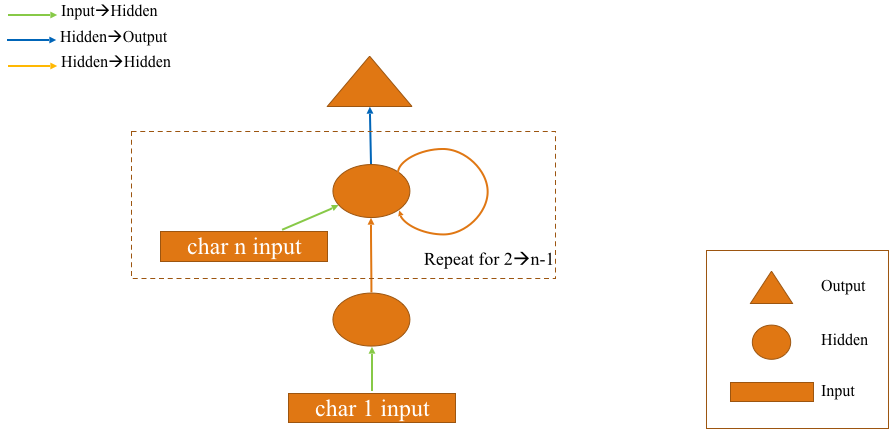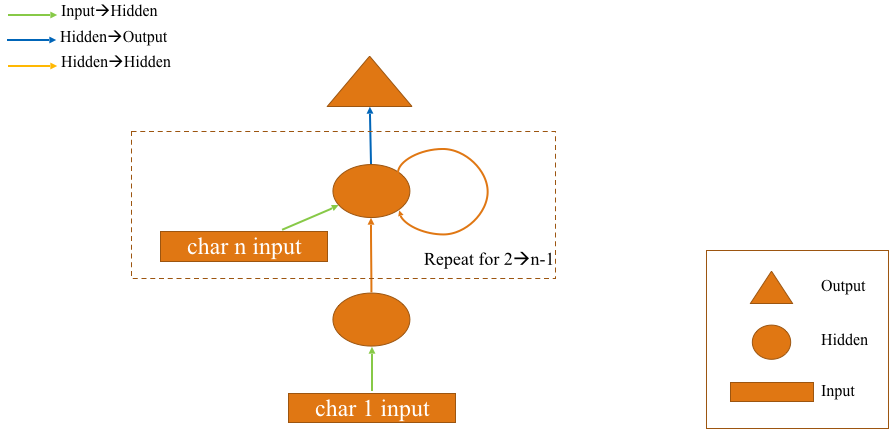

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters. `cs=3` skip over 3 at the time.
```
range(start, stop[, step]) -> range object
```

In [16]:
cs=3
c1_dat = [idx[i]   for i in range(0, len(idx)-1-cs, cs)]  # 0th character
c2_dat = [idx[i+1] for i in range(0, len(idx)-1-cs, cs)]
c3_dat = [idx[i+2] for i in range(0, len(idx)-1-cs, cs)]
c4_dat = [idx[i+3] for i in range(0, len(idx)-1-cs, cs)]  # 3rd character

In [17]:
len(c1_dat), c1_dat[:6], c2_dat[:6], c3_dat[:6], c4_dat[:6]

(200297,
 [40, 30, 29, 1, 40, 43],
 [42, 25, 1, 43, 40, 33],
 [29, 27, 1, 45, 39, 38],
 [30, 29, 1, 40, 43, 31])

In [18]:
import numpy as np

Our inputs converted to np using `np.asarray`. 
JH was using `np.stack`, but *"np.stack is going to be different for when axis!=0. We used ‘stack’ here because I think this is a better semantic match for what we’re doing."*

In [19]:
x1 = np.asarray(c1_dat[:-2])  # 0 character
x2 = np.asarray(c2_dat[:-2])  # 1 character
x3 = np.asarray(c3_dat[:-2])  # 2 character

In [20]:
type(x1), x1

(numpy.ndarray, array([40, 30, 29, ..., 67, 68, 72]))

Our output

In [21]:
y = np.asarray(c4_dat[:-2])

The first 4 inputs and corresponding outputs (in following line)

In [22]:
x1[:4], x2[:4], x3[:4]

(array([40, 30, 29,  1]), array([42, 25,  1, 43]), array([29, 27,  1, 45]))

In [23]:
y[:4]

array([30, 29,  1, 40])

In [24]:
x1.shape, y.shape

((200295,), (200295,))

## Create and train FC model
Now using pytorch `nn`.
This will be a Fully connected model, with some interesting additions for state.

In [25]:
import torch 
import torch.nn as nn

We need to decide activations and embedding sizes (experiment with alternatives). We pick:
- `n_hidden = 256` as size for the hidden state
- `n_fac = 42`: number of latent factors to create (i.e. the size of the embedding matrix)

In [26]:
n_hidden = 256   # Activations

n_fac = 42   # about half the number of characters (vocab_size // 2) we have (experimental)

Below `Char3model` is standard FC model.
Each character will go thru an embedding, linear and relu.

```
nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, max_norm=None, 
            norm_type=2, scale_grad_by_freq=False, sparse=False)
```    
A simple lookup table that stores embeddings of a fixed dictionary and size.

- `nn.Linear(in_features, out_features, bias=True)`   
Applies a *linear* transformation to the incoming data: :math:`y = Ax + b`

- `F.relu(input, inplace=False)`
Applies the rectified linear unit function element-wise.

- `F.log_softmax(input, dim=None, _stacklevel=3)`
Applies a softmax followed by a logarithm.

In [27]:
class Char3Model(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()    # access the __init__ class of nn.Module 
        self.e = nn.Embedding(vocab_size, n_fac)  #one embedding

        # The 'green arrow' from our diagram - the layer operation from input to hidden
        self.l_in = nn.Linear(n_fac, n_hidden)

        # The 'orange arrow' from our diagram - the layer operation from hidden to hidden
        self.l_hidden = nn.Linear(n_hidden, n_hidden)   #This is a squared Matrix. "the trick"
        
        # The 'blue arrow' from our diagram - the layer operation from hidden to output
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, c1, c2, c3):
        in1 = F.relu(self.l_in(self.e(c1)))
        in2 = F.relu(self.l_in(self.e(c2)))
        in3 = F.relu(self.l_in(self.e(c3)))
        
        #now activations
        h = V(torch.zeros(in1.size()).cuda())  #this is to make the following 3 lines identical so later loop
        h = F.tanh(self.l_hidden(h+in1))
        h = F.tanh(self.l_hidden(h+in2))
        h = F.tanh(self.l_hidden(h+in3))
        
        return F.log_softmax(self.l_out(h))

In [28]:
from fastai.column_data import ColumnarModelData # *

```
ColumnarModelData.from_arrays(path, val_idxs, xs, y, is_reg=True, 
                            is_multi=False, bs=64, test_xs=None, shuffle=True)
```
We use this fastai library function to create the `md` **data** object for training 

In [78]:
md = ColumnarModelData.from_arrays('.', [-1], np.stack([x1,x2,x3], axis=1), y, bs=512)

In [79]:
m = Char3Model(vocab_size, n_fac).cuda()  #this is a standard pytorch model (not fastai) so we need to add .cuda()

In [31]:
from fastai.conv_learner import V, F   # *

Following code will:
- grab the iterator `it` from the `md.trn_dl` data loader to iterate thru the training set
- grab a minibatch (of size bs=512), returns all the xs and ys tensors
- invokes the model `m` as a function passing the (minibatch) tensor as (minibatch) Variable

In [32]:
it = iter(md.trn_dl) #grab the iterator to iterate thru the training set
*xs,yt = next(it)   #grab a minibatch (of size bs=512), returns all the xs and ys tensors
t = m(*V(xs))  #invoke the model as a function passing the (minibatch) tensor as a (minibatch) Variable

In [33]:
type(xs), type(xs[0]), len(xs), len(xs[0]) # xs is a list of 3 tensors of size bs

(list, torch.Tensor, 3, 512)

In [34]:
#xs[0].size(), xs[0]

For each one below are the (log) probabilities of the characters (a minibatch of 512 out of the 85 in the vocabulary)
computed by `m`.

In [36]:
t, t.size()

(tensor([[-4.3198, -4.4096, -4.3290,  ..., -4.3774, -4.4986, -4.5024],
         [-4.4079, -4.2841, -4.2514,  ..., -4.7119, -4.3666, -4.2898],
         [-4.4538, -4.2680, -4.3656,  ..., -4.6098, -4.2170, -4.4355],
         ...,
         [-4.4479, -4.2131, -4.0874,  ..., -4.5756, -4.4506, -4.3864],
         [-4.5462, -4.2766, -4.2992,  ..., -4.3621, -4.3570, -4.3781],
         [-4.5041, -4.2870, -4.1576,  ..., -4.4908, -4.4769, -4.4462]], device='cuda:0'),
 torch.Size([512, 85]))

`optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)`  
See [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)

In [37]:
import torch.optim as optim

For the pytorch optimizer, pass a list of things to optimize, which are the parameters of the model (m)

In [38]:
opt = optim.Adam(m.parameters(), lr=1e-2)    #pytorch optimizer

In [39]:
from fastai.learner import fit

```
fit(model, data, epochs, opt, crit, metrics=None, callbacks=None, 
    stepper=<class 'fastai.model.Stepper'>, **kwargs)`
```
Now returns the val_loss

In [40]:
%time fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      2.076312   6.629396  

CPU times: user 7.92 s, sys: 116 ms, total: 8.03 s
Wall time: 4.16 s


[6.629395961761475]

In [41]:
from fastai.layer_optimizer import set_lrs
set_lrs(opt, 0.001)   # fastai set the lr for the optimizer

Since it is standard pytorch, we dont have the fastai learning rate finders, SGDR, etc. <br>
so we "manually" do the learning rate annealing.

In [42]:
%time fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.819535   5.839994  

CPU times: user 7.94 s, sys: 171 ms, total: 8.11 s
Wall time: 4.13 s


[5.839993953704834]

In [43]:
%time vl = fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.770323   6.260091  

CPU times: user 7.76 s, sys: 123 ms, total: 7.88 s
Wall time: 4.11 s


In [44]:
vl

[6.2600908279418945]

### Test model

`get_next(inp)` will return the next (predicted) character

In [45]:
from fastai.core import T, VV, to_np

In [80]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))  # T converts to Tensor
    print(*VV(idxs))
    p = m(*VV(idxs))  # convert to variables and pass to model
    i = np.argmax(to_np(p)) # grab the character number, converting it first to np
    return chars[i]

In [81]:
get_next('y. ')  #pass it 3 characters

tensor(78, device='cuda:0') tensor(10, device='cuda:0') tensor(2, device='cuda:0')


'ë'

In [55]:
get_next('ppl'), get_next(' th'), get_next('and')

tensor(69, device='cuda:0') tensor(69, device='cuda:0') tensor(65, device='cuda:0') 

tensor(2, device='cuda:0') tensor(73, device='cuda:0') tensor(61, device='cuda:0') 

tensor(54, device='cuda:0') tensor(67, device='cuda:0') tensor(57, device='cuda:0') 



('e', 'e', ' ')

# Our first RNN!

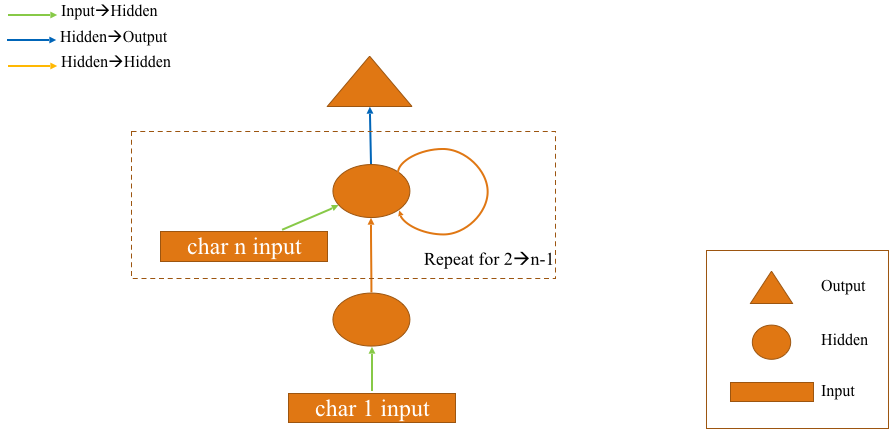
## Create inputs

`cs` is the size of the "unrolled" RNN.
Now we use the first 8 characters to predict the 9th. 
We create inputs and output just like the last time:

In [47]:
cs=8    # 8 characters

For each of 0 through 7, create a list of every 8th character with that starting point. 
These will be the 8 inputs to the model.  
j will go from 0 to len(idx)-cs-1.

In [48]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs-1)]

In [49]:
c_in_dat[:10]

[[40, 42, 29, 30, 25, 27, 29, 1],
 [42, 29, 30, 25, 27, 29, 1, 1],
 [29, 30, 25, 27, 29, 1, 1, 1],
 [30, 25, 27, 29, 1, 1, 1, 43],
 [25, 27, 29, 1, 1, 1, 43, 45],
 [27, 29, 1, 1, 1, 43, 45, 40],
 [29, 1, 1, 1, 43, 45, 40, 40],
 [1, 1, 1, 43, 45, 40, 40, 39],
 [1, 1, 43, 45, 40, 40, 39, 43],
 [1, 43, 45, 40, 40, 39, 43, 33]]

Now create a list `c_out_dat` of the next (+cs) characters in each of these series, i.e., the labels for the model.
NB: there are overlaps (i.e., 0–7 to predict 8, 1–8 to predict 9).

In [50]:
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs-1)]

In [51]:
c_out_dat[:10]

[1, 1, 43, 45, 40, 40, 39, 43, 33, 38]

Original used the slower 
`np.stack(c_in_dat, axis=0)`, we replaced by:
`xs = np.asarray(c_in_dat)`

In [52]:
xs = np.asarray(c_in_dat)

xs.shape

(600884, 8)

In [53]:
xs[:10]   # The first 10 sequences of 8 chars each

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39],
       [ 1,  1, 43, 45, 40, 40, 39, 43],
       [ 1, 43, 45, 40, 40, 39, 43, 33]])

In [54]:
y = np.asarray(c_out_dat)

So each column below is one series of 8 characters from the text.

In [55]:
xs[:cs,:cs]

array([[40, 42, 29, 30, 25, 27, 29,  1],
       [42, 29, 30, 25, 27, 29,  1,  1],
       [29, 30, 25, 27, 29,  1,  1,  1],
       [30, 25, 27, 29,  1,  1,  1, 43],
       [25, 27, 29,  1,  1,  1, 43, 45],
       [27, 29,  1,  1,  1, 43, 45, 40],
       [29,  1,  1,  1, 43, 45, 40, 40],
       [ 1,  1,  1, 43, 45, 40, 40, 39]])

...and this is the next character after each sequence.

In [56]:
y[:cs]

array([ 1,  1, 43, 45, 40, 40, 39, 43])

## Create and train model

`get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42)` from fastai<br>
Get a list of index values for Validation set from a dataset with Arguments:<br>
- n : int, Total number of elements in the data set.
- cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
- val_pct : (int, float), validation set percentage 
- seed : seed value for RandomState
- **Returns**: list of indexes 

In [57]:
from fastai.dataset import get_cv_idxs

In [58]:
val_idx = get_cv_idxs(len(idx)-cs-1)   # By default returns 20%

In [59]:
len(val_idx), val_idx

(120176, array([480310, 419017, 232803, ..., 134355, 389158, 330599]))

`md` is the data object.

In [60]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, y, bs=512)

`CharLoopModel(nn.Module)` is an RNN!

Code is as before, but: 
- now there is a for-loop in the forward function.
- use of `tanh`.

In [61]:
class CharLoopModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)    #Embedding Layer
        self.l_in = nn.Linear(n_fac, n_hidden)      #in linear
        self.l_hidden = nn.Linear(n_hidden, n_hidden) #hidden
        self.l_out = nn.Linear(n_hidden, vocab_size) # out
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:   #here is the loop
            inp = F.relu(self.l_in(self.e(c)))
            h = F.tanh(self.l_hidden(h+inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

This now is a deeper network, 8 chars vs 2 before. 
As DNNs get deeper, they become harder to train.

In [62]:
m = CharLoopModel(vocab_size, n_fac).cuda() 
opt = optim.Adam(m.parameters(), 1e-2)

In [63]:
%time fit(m, md, 1, opt, F.nll_loss)  # 22 secs on 1080 GPU

epoch      trn_loss   val_loss                              
    0      2.00675    2.000459  

CPU times: user 37.3 s, sys: 2.42 s, total: 39.8 s
Wall time: 27.1 s


[2.0004592767140785]

In [64]:
set_lrs(opt, 0.001)

In [65]:
%time fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.708633   1.716925  

CPU times: user 37.1 s, sys: 2.38 s, total: 39.5 s
Wall time: 26.9 s


[1.7169250544910026]

## Concatenating instead of adding
Adding things together may loose information. 
Lets use concatenation which is better in those cases.
When we have information, even if it is of the same dimension, 
**concatenating preserves more information than adding.**

NB changes: 
- we pass `n_fac+n_hidden` to the first nn.Linear layer, 
to get the right dimensions (size for concatenation) in the input layer.
- use `torch.cat((h, self.e(c)), 1)` in the forward loop.

(Don’t forget to change the input to match the shape (`n_fac+n_hidden` instead of `n_fac`).)

In [86]:
class CharLoopConcatModel(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.l_in = nn.Linear(n_fac+n_hidden, n_hidden) # concatenation
        self.l_hidden = nn.Linear(n_hidden, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        #if (cs[0].dim() == 1):
            bs = cs[0].size(0)
        #if (cs[0].dim() == 0): bs = len(cs)
               
        h = V(torch.zeros(bs, n_hidden).cuda())
        for c in cs:
            inp = torch.cat((h, self.e(c)), 1)   #now concatenate instead of adding
            inp = F.relu(self.l_in(inp))
            h = F.tanh(self.l_hidden(inp))
        
        return F.log_softmax(self.l_out(h), dim=-1)

In [87]:
m = CharLoopConcatModel(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

The code below is not necessary, just use it if need to show t as was done earlier.

In [108]:
it = iter(md.trn_dl)
*xs,yt = next(it)
t = m(*V(xs))

In [88]:
%time vl1 = fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      2.109764   5.683479  

CPU times: user 7.78 s, sys: 139 ms, total: 7.92 s
Wall time: 4.12 s


In [65]:
set_lrs(opt, 1e-4)

In [66]:
%time vls2 = fit(m, md, 1, opt, F.nll_loss)

epoch      trn_loss   val_loss                              
    0      1.973708   4.561224  

CPU times: user 7.87 s, sys: 183 ms, total: 8.05 s
Wall time: 4.27 s


Improved the val_loss to 1.707

### Test model

In [82]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
get_next('for thos') 
#get_next('ppl'), get_next(' th'), get_next('and')

tensor(59, device='cuda:0') tensor(68, device='cuda:0') tensor(71, device='cuda:0') tensor(2, device='cuda:0') tensor(73, device='cuda:0') tensor(61, device='cuda:0') tensor(68, device='cuda:0') tensor(72, device='cuda:0')


RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 1 and 2 at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCTensorMath.cu:102

> <ipython-input-86-6cf01022d005>(16)forward()
     14         h = V(torch.zeros(bs, n_hidden).cuda())
     15         for c in cs:
---> 16             inp = torch.cat((h, self.e(c)), 1)   #now concatenate instead of adding
     17             inp = F.relu(self.l_in(inp))
     18             h = F.tanh(self.l_hidden(inp))

ipdb> p h
tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')
ipdb> p bs
8


# RNN with pytorch nn.RNN
Now lets use Pytorch `nn.RNN` (instead of nn.Linear) to do:
- the writing of the loop in the forward (with a starting point) and 
- create the input linear layers.
Pytorch appends a hidden state, so it returns all of them, i.e.,
`self.rnn` will return not only the output but also the hidden state.
In other words, 
`self.rnn` will append a new hidden state to a tensor instead of replacing,
(i.e., it will give back all ellipses in the diagram). <br>
Since now we care only for the last one, we use outp[-1]

Problem is that in the forward below we keep throwing away the hidden $h$.
So we will fix this in the next part.

In [ ]:
class CharRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)    #Pytorch rnn returns all the hidden states in h
        
        return F.log_softmax(self.l_out(outp[-1]), dim=-1)   #outp[-1] because we only care for the last one

- PyTorch version — nn.RNN will create the loop and keep track of h as it goes along.
- We are using white section to predict the green character — which seems wasteful as the next section mostly overlaps with the current section.
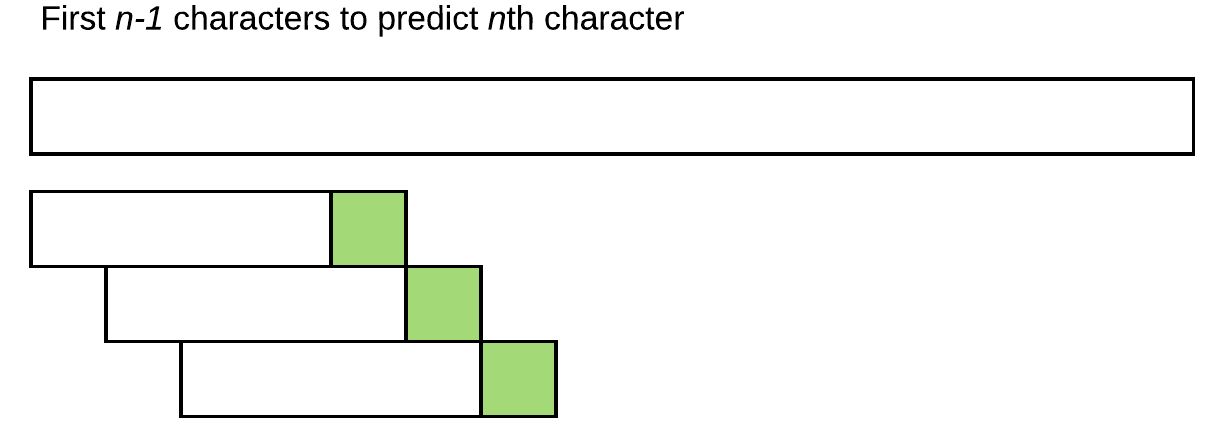

In [ ]:
m = CharRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
it = iter(md.trn_dl)
*xs,yt = next(it)

In [ ]:
t = m.e(V(torch.stack(xs)))
t.size()

In [ ]:
ht = V(torch.zeros(1, 512,n_hidden))
outp, hn = m.rnn(t, ht)
outp.size(), hn.size()

In PyTorch, a hidden state is rank 3 tensor 
```
h = V(torch.zeros(1, bs, n_hidden))
```
(in our version, it was rank 2 tensor) 
[1:51:58](https://youtu.be/sHcLkfRrgoQ?t=1h51m58s). 

More about this later: we can have a second RNN that goes backwards. 
- “bi-directional RNN”: better at finding relationships that go backwards
- “multi layer RNN”: RNN feeds to an RNN
For these RNNs, we will need the additional axis in the tensor to keep track of additional layers of hidden state. 
For now, we will just have 1 there, and get back 1.

In [ ]:
t = m(*V(xs)); t.size()

In [ ]:
%time fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
%time fit(m, md, 2, opt, F.nll_loss)

## Test model

In [ ]:
get_next('for thos'), get_next('part of '), get_next('queens a')

`get_next_n()` used to look forward multiple chars.
Loops n times calling get_next each time, and each time we replace input 
by removing the first character and adding the character we just predicted.

In [ ]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
get_next_n('for thos', 40), get_next_n('part of ', 40), get_next_n('queens a', 40)

Notice the repetitions on the output... we will address this later.

## Multi-output model

From the last diagram, we can simplify even further by treating char 1 the same as char 2 to n-1. You notice the triangle (the output) also moved inside of the loop, in other words, we create a prediction after each character.

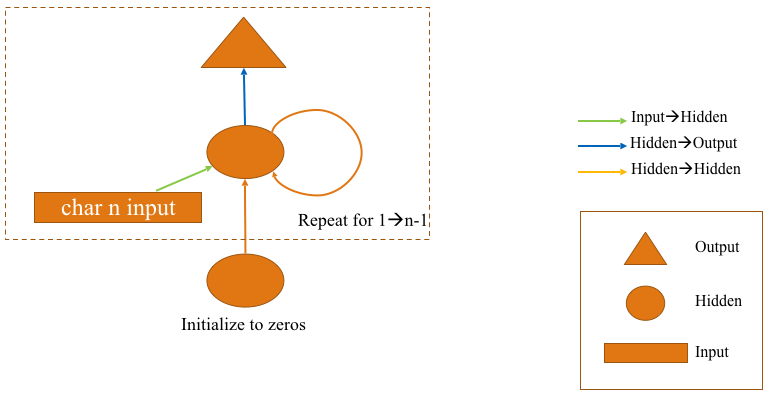

### Setup

Let's take non-overlapping sets of characters this time. 
Recall the overlapping set was done by
```
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs-1)]
```
so now to avoid the overlap, lets use: `range(start, stop[, step])`

In [ ]:
c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]

In [ ]:
c_in_dat[:10]

Then create the exact same thing, offset by 1, as our labels

In [ ]:
c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

In [ ]:
xs = np.stack(c_in_dat)
xs.shape  # shape is now 600884/8, as we are looking at 8 non-overlapping characters

In [ ]:
ys = np.stack(c_out_dat)
ys.shape

We can make it more efficient by taking non-overlapping sets of characters this time. 
Because we are doing multi-output, for an input char 0 to 7, the output would be the predictions for char 1 to 8.

In [ ]:
xs[:cs,:cs]   # using non-overlapping characters

In [ ]:
ys[:cs,:cs]

### Create and train model

In [ ]:
val_idx = get_cv_idxs(len(xs)-cs-1)

In [ ]:
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=512)

This will not make our model any more accurate, but we can train it more efficiently.

In the earlier `CharRNN` the softmax used `outp[-1]`, because we only cared for the last one.
This time we would use the full `outp` so we get them all....

In [ ]:
class CharSeqRnn(nn.Module):
    def __init__(self, vocab_size, n_fac):
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        h = V(torch.zeros(1, bs, n_hidden))
        inp = self.e(torch.stack(cs))
        outp,h = self.rnn(inp, h)
        return F.log_softmax(self.l_out(outp), dim=-1)

In [ ]:
m = CharSeqRnn(vocab_size, n_fac).cuda()   # cuda(1) to use the 2nd GPU 
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
it = iter(md.trn_dl)
*xst,yt = next(it)

[Video](https://youtu.be/sHcLkfRrgoQ?t=2h37s)
We have a rank 3 tensor (8x84x512):
- 8 characters (time steps) for each of them we have 
- 84 probabilities for every character, and that for each of the 
- 512 items in the minibatch.

But the (current?) pytorch loss function expects rank 2 tensors.. (bad design)
So, we now write our own *custom loss function* for sequences, `nll_loss_seq(inp, targ)`
It will call the pytorch one `F.nll_loss`
We need to flatten our input (using `.size` to pull them) and flatten our targets.
We also need to transpose the axes (out target and the resource are opposites)
In pytorch the axes expected are:
1. sl: sequence length (eg 8)
2. bs: batch size (eg 512)
3. nh: hidden state (eg 256, n_hidden)

Because of an issue with Pytorch (see below) we need to invoke `contiguous` 
and invoke `.view` which is like reshape to flatten the input.
(.view is same as np.reshape. -1 indicates as long as it needs to be.)

PyTorch does not shuffle the memory order when you do e.g. ‘transpose’.
Instead it keeps some internal metadata to treat it "as if" it is transposed. 
When we transpose a matrix, PyTorch just updates the metadata. 
**NB:** If you ever see an error **“this tensor is not continuous”** , add .contiguous() after it and error goes away.

In [ ]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size() # need to transpose the first 2 axis to be sl, bs, number hidden 8, 512, 256
    targ = targ.transpose(0,1).contiguous().view(-1)  
    #contiguos to avoid a pytorch error message, -1 == as long as needs to be
    return F.nll_loss(inp.view(-1,nh), targ)  # invoke the pytorch nll loss function

So now we can pass the custom loss function `nll_loss_seq` to `fit`.
Recall that in `fit()` the parameters are all standard pytorch, except for the 2nd parameters, `md`,
our data object.

In [ ]:
%time fit(m, md, 4, opt, nll_loss_seq)

Q: Now that we put a triangle inside of the loop, do we need a bigger sequence size?

If we have a short sequence like 8, the first character has nothing to go on. 
It starts with an empty hidden state of zeros.
We will learn how to avoid that problem later.
The idea is “why should we reset the hidden state to zeros every time?” (see code below). 
If we can line up these mini-batches somehow, 
so that the next mini-batch joins up correctly representing the next letter in Nietsche’s works, 
then we can move `h = V(torch.zeros(1, bs, n_hidden))`  to the constructor.

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
%time fit(m, md, 1, opt, nll_loss_seq)

### Identity init to avoid Gradient Explosion
One problem is that we could get **gradient explosion**...<br>
`self.rnn(inp, h)` is a loop applying the same matrix multiply again and again. 
If that matrix multiply tends to increase the activations each time, we are effectively doing that to the power of 8 — a gradient explosion.<br>
We want to make sure the initial `l_hidden` will not cause our activations on average to increase or decrease.

To avoid explosions, lets use the Identity Matrix for initialization (instead of random), based on G. Hinton paper 
[A Simple Way to Initialize Recurrent Networks of Rectified Linear Units](https://arxiv.org/abs/1504.00941)

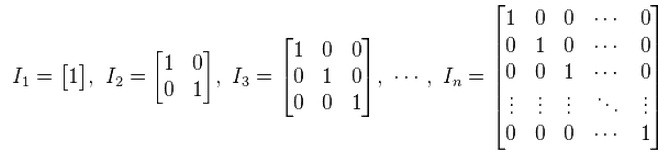

In [ ]:
m = CharSeqRnn(vocab_size, n_fac).cuda()
opt = optim.Adam(m.parameters(), 1e-2)

See `m.rnn` to see the attributes that are learneable.
Specificaly, `weight_hh_l[k]` : the learnable hidden-hidden weights of the k-th layer.
This initialization improves our results significantly.            

    #??m.rnn

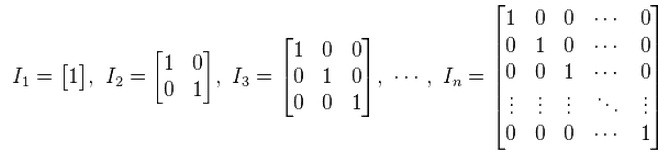

We can overwrite the randomly initialized hidden-hidden weight with an identity matrix:

In [ ]:
m.rnn.weight_hh_l0.data.copy_(torch.eye(n_hidden))   #eye is the identity matrix

In [ ]:
%time fit(m, md, 4, opt, nll_loss_seq)

In [ ]:
set_lrs(opt, 1e-3)

In [ ]:
%time fit(m, md, 4, opt, nll_loss_seq)

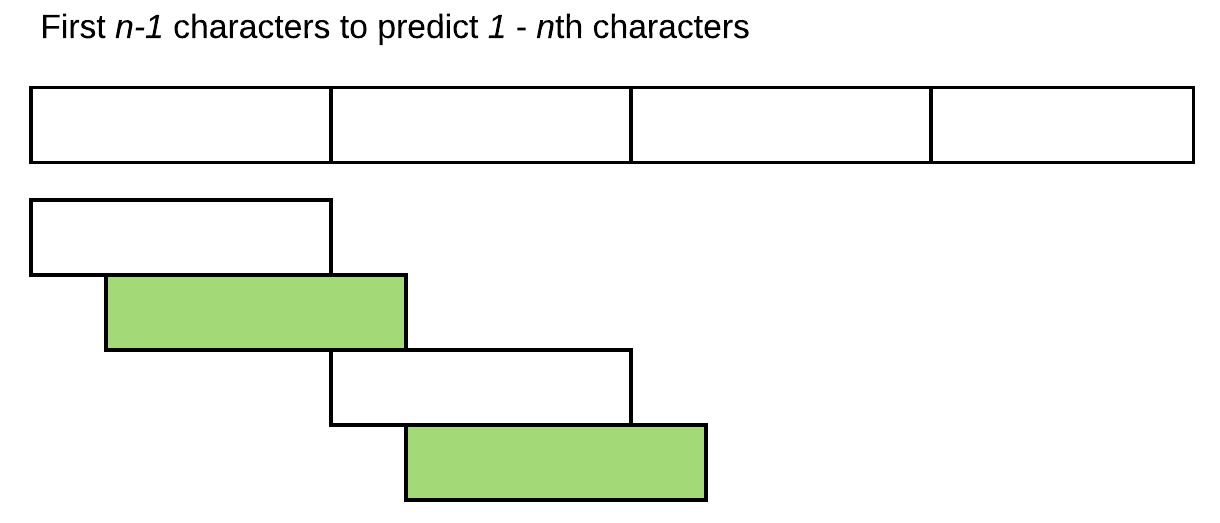

In this approach, we are throwing away our h activation after processing each section and started a new one. In order to predict the second character using the first one in the next section, it has nothing to go on but a default activation. Let’s not throw away h .


## Stateful RNN model

### Setup

In [ ]:
from fastai.nlp import LanguageModelData #*
from fastai.lm_rnn import repackage_var  #*

Recall that at the beginning we did:
```
TEXT = data.Field(lower=True, tokenize=list)
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
```

Parameters for the model:
- bs = batch size
- bptt = backprop thru time
- n_fac size of embedding
- n_hidden: size of the hidden "circles" 

In [ ]:
bs=64; bptt=8; n_fac=42; n_hidden=256

md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=3)
print(" minibatchlength=", len(md.trn_dl), "number of tokens=", md.nt)
len(md.trn_ds), len(md.trn_ds[0].text)   # definitions?

After the model is created via `LanguageModelData.from_text_files`:
- `TEXT` will contain an extra attribute called vocab. 
    - `TEXT.vocab.itos` list of unique items in the vocabulary, and 
    - `TEXT.vocab.stoi` is a reverse mapping from each item to number.

In [ ]:
md.trn_ds

In [ ]:
#TEXT.vocab

Pytorch "randomizes" the size of bptt for each minibatch. Sometimes a little smaller, etc.

## RNN

We have 4 issues to address below..

### BPTT

- Wrinkle #1, MEMORY: we can get into a back-prop thru too many layers...
If we were to simply do `self.h = h`, and we trained on a document that is 1M characters long, 
then the size of the unrolled RNN has 1M layers (ellipses). 
1M  million layer FC network is memory intensive: 
to do a chain rule, we have to multiply 1M layers while remembering 1M gradients every batch.<br>
To avoid this, we tell it to forget its history from time to time. 

**Solution: Forget some of your history**
We want to remember the current state, (the values in our hidden matrix) 
but not all the history on how we got there.

The difference below is that we invoke `init_hidden()` as part of the constructor.
If we did not use `repackage_var` there would be too many layers, which will be very memory intensive.

`self.h = repackage_var(h)` - will get the tensor (activations) out of the variable, 
and make a new variable out of that. (but no history of operations).
It will backpropogate through 8 layers, but throw away the history of operations.
This is `Back-Prop Thru time (BPTT)`.

Other reasons for BPTT:
- the larger number of layers, the harder it is to train... 
- exploding gradients; more layers, more chances the gradients will explode.

The value of `bptt` indicates how many layers to back-prop thru.
Larger value implies more memory. 
```
repackage_var(h): Wraps h in new Variables, to detach them from their history
    return Variable(h.data) if type(h) == Variable else tuple(repackage_var(v) for v in h) 
```
File:      ~/fastai/courses/dl1/fastai/lm_rnn.py

### How to split the data (chunks) into batches
Wrinkle #2, we need to properly split the chunks. <br>
First we split the (large) text into $n$, e.g., $n=64$ chunks. 
Then we look at subsets of size `bptt` in parallel.
See [Lesson 6](https://www.youtube.com/watch?v=H3g26EVADgY&t=1195s)
00:17:50 
- Creating mini-batches, “split in 64 equal size chunks” not “split in chunks of size 64”, 
questions on data augmentation and choosing a BPTT size, PyTorch QRNN.
- The chunks are of size=`BPTT * BS`. This size should fit into the GPU memory. 
If performance is too slow, lowering the BPTT may expedite it.

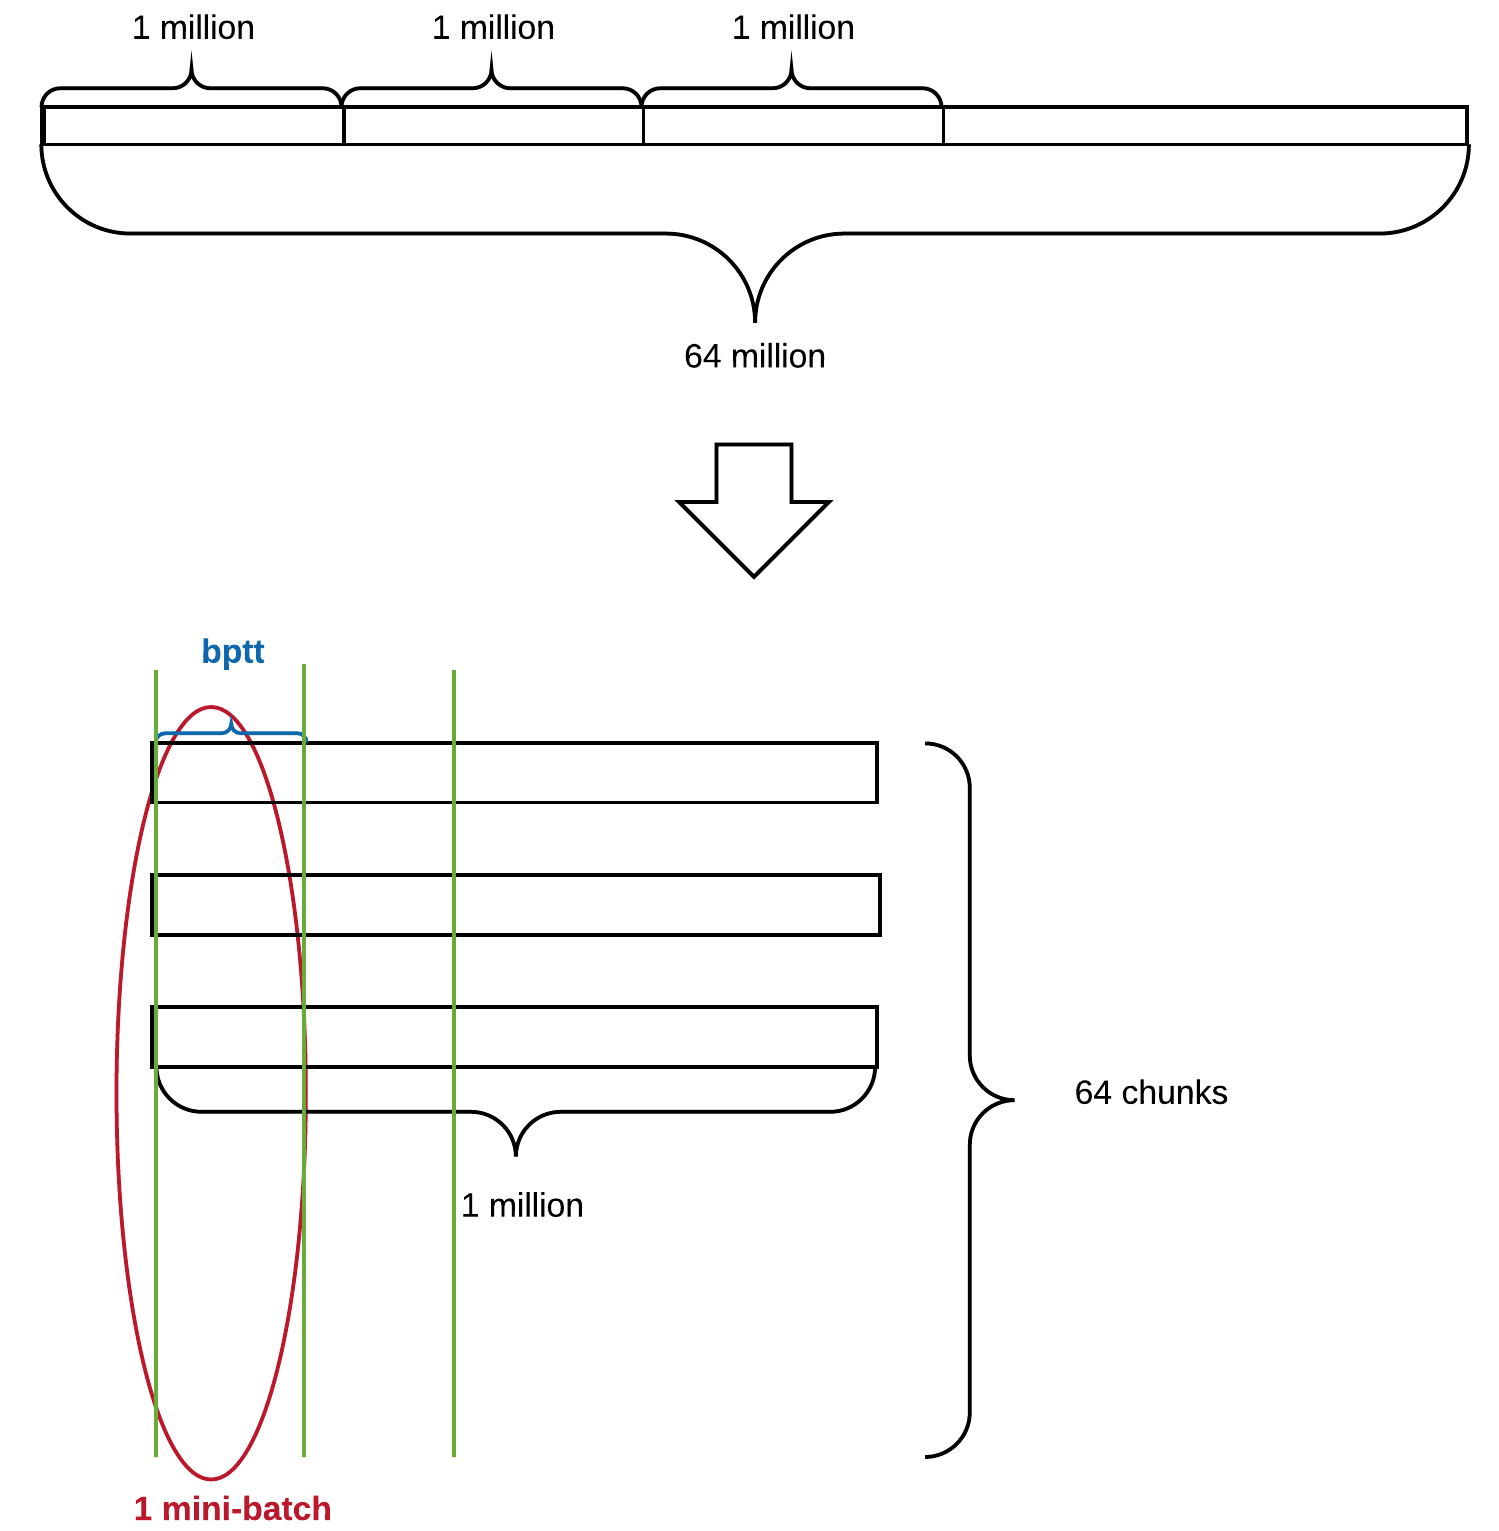

- For a document that is 64 million characters long, each “chunk” will be 1 million characters. 
We stack them together and now split them by bptt — 1 mini-bach consists of 64 by bptt matrix.
- The first character of the 2nd chunk(1,000,001th character) is likely to be in the middle of a sentence. 
OK since it only happens once every million characters.

In this section we will use torchtext again....  

The class `CharSeqStatefulRnn` is similar to before, 
with an additional line in the __init__ constructor: 
`self.init_hidden(bs)` initializes `self.h` to zeros.
Now **h** is an attribute of the Module, which starts as a Variable set as zeros.  

In [ ]:
class CharSeqStatefulRnn(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        self.vocab_size = vocab_size
        super().__init__()
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNN(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        #check for the last batch, as for each epoch we need to reinitialize, for end of each epoch start of each epoch problem 
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)   # now it takes self.h as input
        self.h = repackage_var(h)    # now store it throwing away history of operations
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

### Wrinkle #3 Last mini-batch is shorter.
[33:51] 
The last mini-batch is (likely) shorter than the rest 
(unless the dataset is exactly divisible by `bptt` $\times$ `bs`).<br> 
So we do: 
```
if self.h.size(1) != bs: self.init_hidden(bs)
```
If the size of `h`‘s second dimension is NOT the same as `bs`, we set it back to the full bs of zeros.
This (setting back to the full batch size) happens at the end (and at the beginning??) of the epoch.

### Wrinkle 4: PyTorch not accepting a “Rank 3 Tensor”
00:35:43 Dealing with PyTorch not accepting a “Rank 3 Tensor”, only Rank 2 or 4, `F.log_softmax()`
Pytorch loss functions are not "happy" receiving Tensors of rank 3.  
JH: not good reason for this... it expects a rank 2 (or rank 4) tensor.  

We need to use `.view()` to flatten out the input. 
The number of columns will be the `vocab_size`, 
while the number of rows is "-1", ie whatever is needed (ie bs * bptt).
For the target, `torchtext` automatically changes the target to be flatten.

- `.view` will reshape rank 3 tensor into rank 2 of -1 (however big as necessary) by `vocab_size`. 
TorchText automatically changes the target to be flattened out, so we do not need to do that for actual values.

NB: pytorch 0.3 requires that we tell it over which axis to sum over (softmax). 
Above we passed the last axis `dim=-1`, the probability per letter of the vocabulary. 

In [ ]:
m = CharSeqStatefulRnn(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
%time fit(m, md, 4, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

%time fit(m, md, 4, opt, F.nll_loss)

### RNN loop

From the pytorch source, just for reference, no need to execute it.
Notice that they do **not** concatenate the input and the hidden state, 
but they sum them together — which was our first approach):
```
def RNNCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    return F.tanh(F.linear(input, w_ih, b_ih) + F.linear(hidden, w_hh, b_hh))
``` 
Let’s gain more insight by unpacking RNN [42:48]
We replace `nn.RNN` with `nn.RNNCell` . 

In [ ]:
class CharSeqStatefulRnn2(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.RNNCell(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp = []
        o = self.h
        for c in cs: 
            o = self.rnn(self.e(c), o)
            outp.append(o)
        outp = self.l_out(torch.stack(outp))
        self.h = repackage_var(o)
        return F.log_softmax(outp, dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

- for-loop is back and appends the result of linear function to a list — which in end gets stacked up together.
- fast.ai library does exactly this in order to use regularization approaches that are not supported by PyTorch.

In [ ]:
m = CharSeqStatefulRnn2(md.nt, n_fac, 512).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
%time fit(m, md, 4, opt, F.nll_loss)

NB: Nobody uses `RNNCell` since even with tanh, gradient explosions are still a problem,
and we need use low learning rate and small bptt to get them to train. 
So we replace RNNCell with something like `GRUCell` .

### GRU (Gated Recurrent Unit) Cell
 A gating mechanism in RNNs, introduced in [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078). 
Their performance on polyphonic music modeling and speech signal modeling was found to be similar to that of long short-term memory. 
However, GRUs have been shown to exhibit better performance on smaller datasets.

See below http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png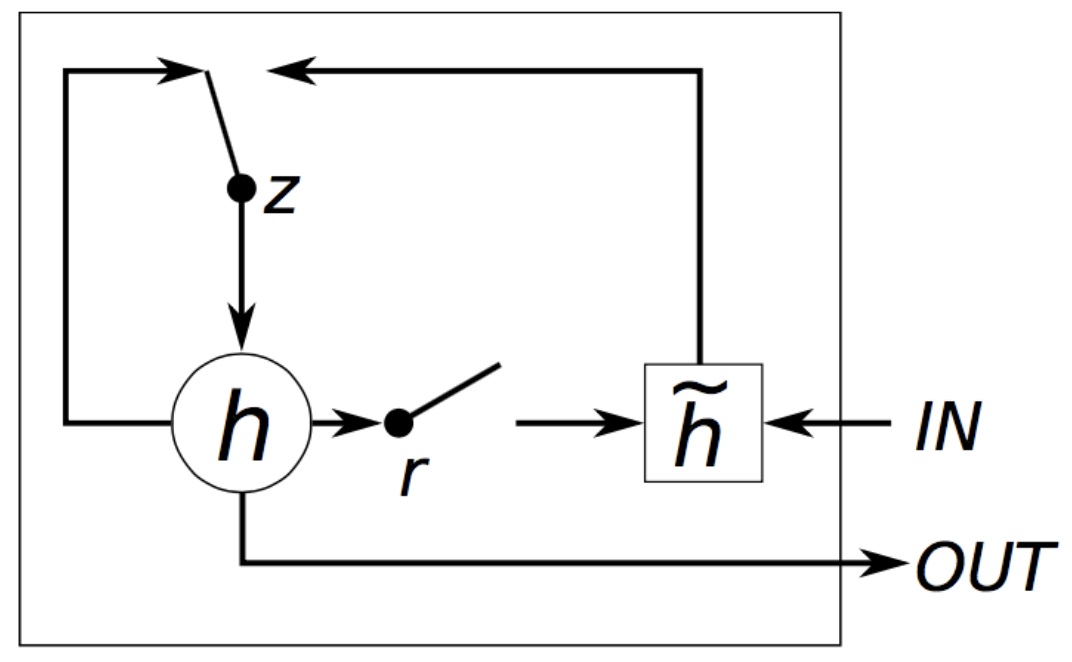

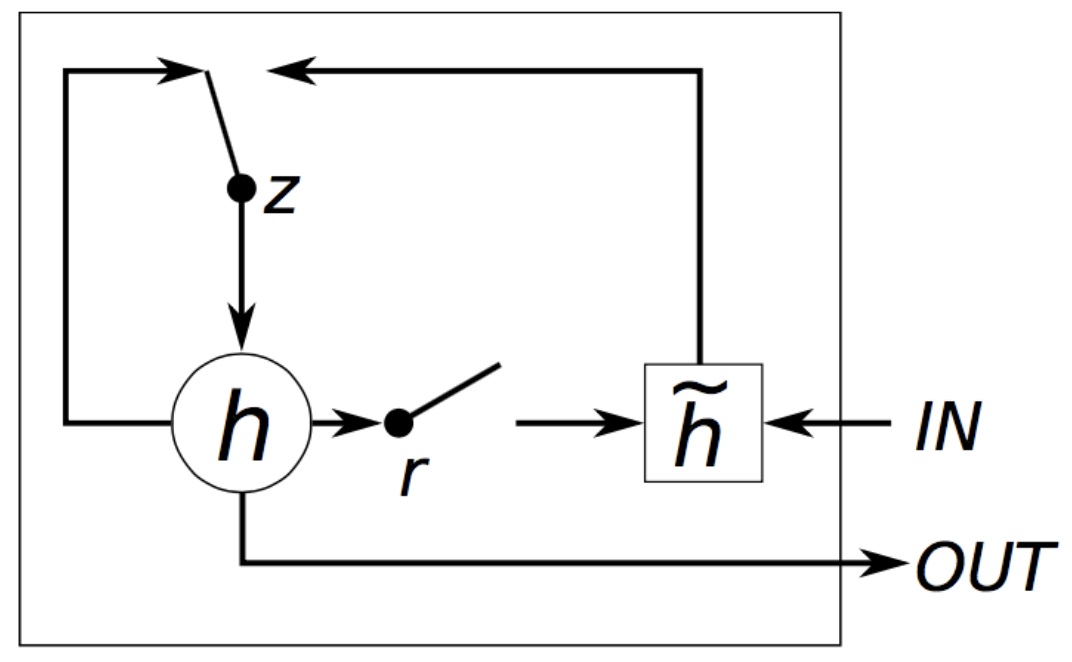

Uses a mini-neural-net to decide when to throw away (reset) information, e.g., when it sees a ".".
Also has an outtake gate, $z$, to decide when and by how much to update the hidden state.

- Normally, the input gets multiplied by a weight matrix to create new activations `h` and gets added to the existing activations straight away. That is **not** what happens here.
Input goes into $\tilde{h}$ and it doesn’t just get added to the previous activations, 
but the previous activation gets multiplied by $r$ (reset gate) which has a value of 0 or 1.

- the $r$ is calculated as below — matrix multiplication of some weight matrix and the concatenation of our previous hidden state and new input. 
This is a (little) one hidden layer "mini" NN. 
It also gets put through the sigmoid function. 
The mini NN learns to determine how much of the hidden states to remember.
For example, maybe forget it all when it sees a full-stop character — beginning of a new sentence).
- The $z$ gate (update gate) determines to what degree to use $\tilde{h}$ 
(the new input version of hidden states) and to what degree to leave the hidden state the same as before.

In [ ]:
from IPython.display import Image
Image(url='http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png')

Linear interpolation
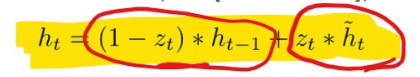

In [ ]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.GRU(n_fac, n_hidden)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h.size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs): self.h = V(torch.zeros(1, bs, n_hidden))

In [ ]:
# From the pytorch source code - for reference

def GRUCell(input, hidden, w_ih, w_hh, b_ih, b_hh):
    gi = F.linear(input, w_ih, b_ih)
    gh = F.linear(hidden, w_hh, b_hh)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)

    resetgate = F.sigmoid(i_r + h_r)
    inputgate = F.sigmoid(i_i + h_i)
    newgate = F.tanh(i_n + resetgate * h_n)
    return newgate + inputgate * (hidden - newgate)

In [ ]:
m = CharSeqStatefulGRU(md.nt, n_fac, 512).cuda()

opt = optim.Adam(m.parameters(), 1e-3)

In [ ]:
%time fit(m, md, 6, opt, F.nll_loss)

In [ ]:
set_lrs(opt, 1e-4)

In [ ]:
%time fit(m, md, 3, opt, F.nll_loss)

As a result, we can lower the loss down to 1.42 (RNNCell loss was 1.54). 
In practice, GRU and LSTM are what people use.

# Putting it all together: LSTM
See [Understanding LSTM Networks by Colah](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

LSTM has the "cell state" in addition to the hidden, so we return a tuple of matrices.
Added dropout (after each time step) and doubled the size of the hidden layer.j

In [ ]:
from fastai import sgdr
n_hidden=512

In [ ]:
class CharSeqStatefulLSTM(nn.Module):
    def __init__(self, vocab_size, n_fac, bs, nl):
        super().__init__()
        self.vocab_size,self.nl = vocab_size,nl
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn = nn.LSTM(n_fac, n_hidden, nl, dropout=0.5)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, cs):
        bs = cs[0].size(0)
        if self.h[0].size(1) != bs: self.init_hidden(bs)
        outp,h = self.rnn(self.e(cs), self.h)
        self.h = repackage_var(h)
        return F.log_softmax(self.l_out(outp), dim=-1).view(-1, self.vocab_size)
    
    def init_hidden(self, bs):
        self.h = (V(torch.zeros(self.nl, bs, n_hidden)),
                  V(torch.zeros(self.nl, bs, n_hidden)))

The code is similar to GRU. 
Added `dropout=0.5` to do dropout after each time step and doubled the hidden layer.
— hoping that it will be able to learn more and be resilient as it does so.

In [ ]:
m = CharSeqStatefulLSTM(md.nt, n_fac, 512, 2).cuda()

But now, instead of using the pytorch optimizer, we use the fastai 
`LayerOptimizer(opt_fn, layer_groups, lrs, wds=None)` from 
File:           ~/fastai/courses/dl1/fastai/layer_optimizer.py
which add learning rate and weight decay.

In [ ]:
from fastai.layer_optimizer import LayerOptimizer

In [ ]:
lo = LayerOptimizer(optim.Adam, m, 1e-2, 1e-5)

In [ ]:
lo.opt

In [ ]:
import os

In [ ]:
os.makedirs(f'{PATH}models', exist_ok=True)

In [ ]:
fit(m, md, 2, lo.opt, F.nll_loss)

### Callback 
Now we can pass a function as a a callback to `fit` to dynamically change the learning rate.
Below we pass the `CosAnneal(layer_opt, nb, on_cycle_end=None, cycle_mult=1)` from fastai.sgdr, 
which will update the learning rates when we call `fit`.
- `layer_opt` is the optimizer object, 
- `nb` is the length of an epoch, eg `len(md.trn_dl)`, how many minibatches in an epoch (needed to know how often to reset).
Then automatically save the model (passing another callback, `on_end`, which uses fastai `save_model`).

In [ ]:
from fastai.sgdr import CosAnneal
from fastai.torch_imports import save_model

After creating a standard PyTorch model, we usually do something like 
```
opt = optim.Adam(m.parameters(), 1e-3). 
```
Instead, now we use fast.ai `LayerOptimizer` which takes: 
an optimizer `optim.Adam`, our model `m`, 
learning rate = 1e-2 , and optionally weight decay 1e-5 .

Main reason `LayerOptimizer` exists is to do DLRs and discriminative weight decay. 
The reason we need to use it is that all of the mechanics inside fast.ai assumes that you have one of these. 
If you want to use callbacks or SGDR in code you are not using the Learner class, you need to use this.
`lo.opt` returns the optimizer.

In [ ]:
on_end = lambda sched, cycle: save_model(m, f'{PATH}models/cyc_{cycle}')
cb = [CosAnneal(lo, len(md.trn_dl), cycle_mult=2, on_cycle_end=on_end)]

In [ ]:
%time fit(m, md, 2**4-1, lo.opt, F.nll_loss, callbacks=cb)

- When we call fit, we can now pass the LayerOptimizer and also callbacks.
Here, we use cosine annealing callback — which requires a LayerOptimizer object. 
It does cosine annealing by changing learning rate inside the `lo` object.
- Concept: Create a cosine annealing callback which is going to update the learning rates in the layer optimizer `lo`. The length of an epoch is `len(md.trn_dl)`, ie, how many mini-batches are in an epoch is the length of the data loader. <br>
Since it is doing cosine annealing, it needs to know how often to reset. 
You can pass in cycle_mult in usual way. 
- We can even save our model automatically just like we did with cycle_save_name in Learner.fit.
- We can do callback at a start of a training, epoch or a batch, or at the end of a training, an epoch, or a batch.
- It has been used for CosAnneal (SGDR), and decoupled weight decay (AdamW), loss-over-time graph, etc.

Fit again starting with a smaller lr.   Wall time: 10min 22s

In [ ]:
%time fit(m, md, 2**6-1, lo.opt, F.nll_loss, callbacks=cb)

## Test LSTM

In [ ]:
def get_next(inp):
    idxs = TEXT.numericalize(inp)
    p = m(VV(idxs.transpose(0,1)))
    r = torch.multinomial(p[-1].exp(), 1)
    return TEXT.vocab.itos[to_np(r)[0]]

In [ ]:
get_next('for thos')

In [ ]:
def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        res += c
        inp = inp[1:]+c
    return res

In [ ]:
print(get_next_n('for thos', 300))

In [ ]:
print(get_next_n('sacrific', 300))

When we were testing CharRnn model, we noticed that it repeated itself over and over. 
`torch.multinomial` used in this new version deals with this problem. 
`p[-1]` to get the final output (the triangle), exp to convert log probability to probability. 
We then use `torch.multinomial` function which will give us a sample using the given probabilities. 
If probability is [0, 1, 0, 0] and ask it to give us a sample, it will always return the 2nd item. 
If it was [0.5, 0, 0.5], it will give the 1st item 50% of the times, and 3rd item 50% of the time 
(review of multinomial distribution)

- To play around with training character based language models like this, try running get_next_n at different levels of loss to get a sense of what it looks like. 
NB: The example above is at 1.25, but at 1.3, it looks like a total junk.
- When playing with NLP, particularly generative models, and the results are OK but not great, 
do not be disheartened. It means you are nearly there!

# END

In [ ]:
t1 = time.clock()
time.ctime(time.time()), (t1 - t0)